# Environment Configuration

In [1]:
import os 
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch

from huggingface_hub import notebook_login
from datasets import load_dataset, load_metric
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

In [2]:
# notebook_login()

# Data Collection

In [3]:
dataset_path = "../dataset"

datasets = load_dataset("imagefolder", data_dir=dataset_path)


datasets

Resolving data files:   0%|          | 0/1322 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/60 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/150 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1322
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 60
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 150
    })
})

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x192 at 0x7F7F6AB49CD0>, 'label': 0}


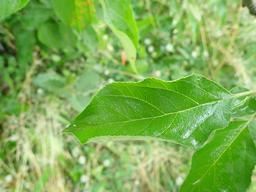

In [4]:
print(datasets["train"][0])

datasets["train"][0]['image']

# Model Selection

In [5]:
# model_id = "microsoft/swin-tiny-patch4-window7-224"
# model_id = "microsoft/resnet-50"
model_id = "google/vit-base-patch16-224"
version = 0
finetuned_model_id = f"plant-image-classifier-v{version}"

# Preprocessing

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as image transformations.

In addition, one typically performs what is called data augmentation during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data.

In [6]:
label2id, id2label = dict(), dict()
for id, label in enumerate(datasets["train"].features["label"].names):
    label2id[label] = id
    id2label[id] = label

id2label

{0: 'Healthy', 1: 'Powdery', 2: 'Rust'}

In [7]:
image_processor  = AutoImageProcessor.from_pretrained(model_id)
image_processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [8]:
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

eval_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply trainuing transformation across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_eval(example_batch):
    """Apply evaluation transformations across a batch."""
    example_batch["pixel_values"] = [eval_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [9]:
datasets["train"].set_transform(preprocess_train)
datasets["validation"].set_transform(preprocess_eval)
datasets["test"].set_transform(preprocess_eval)

datasets["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x192>,
 'label': 0,
 'pixel_values': tensor([[[ 0.5922,  0.5922,  0.5922,  ..., -0.1059, -0.0980, -0.0980],
          [ 0.5922,  0.5922,  0.5922,  ..., -0.0980, -0.0902, -0.0902],
          [ 0.6000,  0.6000,  0.6000,  ..., -0.0196, -0.0118, -0.0118],
          ...,
          [-0.2784, -0.2784, -0.2784,  ...,  0.3725,  0.3490,  0.3490],
          [-0.2627, -0.2627, -0.2627,  ...,  0.3961,  0.3725,  0.3725],
          [-0.2627, -0.2627, -0.2627,  ...,  0.3961,  0.3725,  0.3725]],
 
         [[ 0.8588,  0.8588,  0.8588,  ...,  0.1922,  0.2000,  0.2000],
          [ 0.8588,  0.8588,  0.8588,  ...,  0.2000,  0.2078,  0.2078],
          [ 0.8510,  0.8510,  0.8510,  ...,  0.2784,  0.2863,  0.2863],
          ...,
          [ 0.3725,  0.3725,  0.3804,  ...,  0.5059,  0.4824,  0.4824],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.5294,  0.5059,  0.5059],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.5294,  0.5059,  0.5059]]

# Training

In [10]:
model = AutoModelForImageClassification.from_pretrained(
    model_id, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint,
    trust_remote_code=True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
checkpoint_path = "../checkpoints/"
if os.path.exists(checkpoint_path):
    # Use os.rmdir to remove the folder
    shutil.rmtree(checkpoint_path)

In [12]:
accuracy_metric = load_metric("accuracy", trust_remote_code=True)
f1_metric = load_metric("f1", trust_remote_code=True)

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    references = eval_pred.label_ids
    predictions = np.argmax(eval_pred.predictions, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=references)
    weighted_f1 = f1_metric.compute(predictions=predictions, references=references, average="weighted")
    metrics = accuracy | weighted_f1

    return metrics

def data_collator(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

batch_size = 16
gradient_accumulation_steps = 4
num_train_epochs = 10
learning_rate = 5e-5
warmup_ratio = 0.1
logging_steps = 10
metric_for_best_model = "accuracy"
save_total_limit = 2

training_arguments = TrainingArguments(
    output_dir=checkpoint_path,
    num_train_epochs=num_train_epochs,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    save_total_limit=save_total_limit,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    #auto_find_batch_size=True,
    gradient_accumulation_steps=gradient_accumulation_steps,
    warmup_ratio=warmup_ratio,
    logging_steps=logging_steps,
    load_best_model_at_end=True,
    metric_for_best_model=metric_for_best_model,
    push_to_hub=False,
    remove_unused_columns=False,
)

trainer = Trainer(
    model,
    training_arguments,
    train_dataset=datasets["train"],
    eval_dataset=datasets["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

/tmp/ipykernel_37878/4211832516.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy", trust_remote_code=True)


In [13]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.357700,0.074332,1.000000,1.000000
1,0.100600,0.006966,1.000000,1.000000
2,0.088700,0.003381,1.000000,1.000000
4,0.046700,0.002055,1.000000,1.000000
5,0.041000,0.001677,1.000000,1.000000
6,0.035100,0.001458,1.000000,1.000000
8,0.023200,0.002362,1.000000,1.000000
9,0.028700,0.002244,1.000000,1.000000


# Evaluation

In [16]:
metric_names = ["eval_accuracy", "eval_f1"]
train_evalation_results = trainer.evaluate(datasets["train"])
validation_evalation_results = trainer.evaluate(datasets["validation"])
test_evalation_results = trainer.evaluate(datasets["test"])

evaluatation_results = {
    "train": {metric_name: round(train_evalation_results[metric_name] * 100, 2) for metric_name in metric_names},
    "validation": {metric_name: round(validation_evalation_results[metric_name] * 100, 2) for metric_name in metric_names},
    "test": {metric_name: round(test_evalation_results[metric_name] * 100, 2) for metric_name in metric_names}
}

evaluatation_results

{'train': {'eval_accuracy': 95.31, 'eval_f1': 95.3},
 'validation': {'eval_accuracy': 100.0, 'eval_f1': 100.0},
 'test': {'eval_accuracy': 98.0, 'eval_f1': 97.99}}

# Saving

In [15]:
model_path = f"../models/{finetuned_model_id}"
trainer.save_model(model_path)